# Post-Hoc Analysis - Part 2/2

In [1]:
import os
import sys
from glob import glob
from itertools import product
from typing import Dict, List
from typing import Dict

import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [2]:
PROJ_ROOT = os.path.join(os.pardir)

## About

### Objective

Perform post-topic modeling exploratory data analysis to understand the <span style="color:green">identified topics</span> and <span style="color:green">topic publication patterns</span>.

## User Inputs

In [3]:
#

In [4]:
fname_model_outputs = 'best_model_outputs.parquet.gzip'

article_non_weights_cols = [
    'char_count',
    'sentence_count_raw',
    'year',
    'webPublicationDate',
    'webTitle',
    'text',
    'topic_num',
    'topic_name',
    'topic_name_truncated',
]

num_top_terms = 10
colors_term_weights = {
    0: ['lightgrey']*5+['darkred']*4+['lightgrey']*1,
    1: ['lightgrey']*8+['darkred']*2,
    2: ['lightgrey']*9+['darkred'],
    3: ['lightgrey']*7+['darkred']*3,
    4: ['lightgrey']*8+['darkred']*2,
    5: ['lightgrey']*8+['darkred']*2,
    6: ['lightgrey']*6+['darkred']*4,
}

In [5]:
data_dir = os.path.join(PROJ_ROOT, 'data')
processed_data_dir = os.path.join(data_dir, 'processed', 'guardian')

terms_cols = [f"term_{k}" for k in range(num_top_terms)]
weights_cols = [f"term_{k}_weight" for k in range(num_top_terms)]
cols_to_load = article_non_weights_cols+terms_cols+weights_cols

# filepath of cleaned and combined articles with columns for topic modeling
# outputs
fpath_model_outputs = os.path.join(processed_data_dir, fname_model_outputs)

In [6]:
def get_top_components_per_topic(
    df: pd.DataFrame,
    component_cols: List,
    col_type: str='weight',
) -> pd.DataFrame:
    """Get top 10 terms or weights per topic."""
    df_components = (
        df[['topic_num', 'topic_name_truncated']+component_cols]
        .set_index(['topic_num', 'topic_name_truncated'])
        .drop_duplicates()
        .stack()
        .reset_index()
        .rename(columns={0: col_type})
        .drop(columns=['level_2'])
        .reset_index(drop=True)
    )
    if col_type == 'weight':
        df_components = df_components.sort_values(
            by=['weight'], ascending=False, ignore_index=True
        )
    return df_components


def df_from_cartesian_product(dict_in: Dict) -> pd.DataFrame:
    """Generate a Pandas dataframe from Cartesian product of lists."""
    cart = list(product(*dict_in.values()))
    df = pd.DataFrame(cart, columns=dict_in.keys())
    return df

## Get Data

### Topic Modeling Outputs

In [7]:
%%time
df = (
    pd.read_parquet(fpath_model_outputs, columns=cols_to_load)
    .assign(
        month=lambda df: df['webPublicationDate'].dt.month,
        # combine topic name and number
        topic=lambda df: (
            df['topic_name_truncated']
            .str
            .cat(df['topic_num'].astype(str)+")", sep=' (')
        ),
    )
    .drop(columns=['webPublicationDate'])
    .convert_dtypes()
)
with pd.option_context('display.max_columns', None):
    display(pd.concat([df.head(2), df.tail(2)]))

,char_count,sentence_count_raw,year,webTitle,text,topic_num,topic_name,topic_name_truncated,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,term_0_weight,term_1_weight,term_2_weight,term_3_weight,term_4_weight,term_5_weight,term_6_weight,term_7_weight,term_8_weight,term_9_weight,month,topic
0,3128,514,2019,Our oceans broke heat records in 2018 and the ...,"Last year was the hottest ever measured, conti...",3,Worldwide occurrence of record ocean temperatu...,Global Impact of Record Temperatures on Reefs,ocean,heat,temperatur,warm,climat,heatwav,record,newslett,sea,global,0.192084,0.163982,0.166907,0.185875,0.21696,0.237724,0.240776,0.313417,0.32799,0.468881,1,Global Impact of Record Temperatures on Reefs (3)
1,5571,877,2019,Great Barrier Reef Foundation awards first fun...,The not-for-profit foundation that was awarded...,4,opposition to science-driven GBR water protect...,Agricultural Opposition to GBR Water Protectio...,qualiti,water qualiti,govern,regul,farmer,scienc,report,barrier reef,great barrier,barrier,0.193001,0.193192,0.196054,0.196448,0.199147,0.237542,0.255245,0.281145,0.299211,0.228056,1,Agricultural Opposition to GBR Water Protectio...
259,4325,681,2024,Hope for coral reefs after IVF colonies surviv...,Young corals bred using in vitro fertilisation...,6,Scientific recommendations to counter impact o...,Scientific Recommendations to Offset Impact of...,studi,barrier reef,barrier,great barrier,great,coral reef,climat,larva,cloud,research,0.180724,0.240067,0.212199,0.210676,0.204385,0.204148,0.185955,0.185765,0.183259,0.178643,9,Scientific Recommendations to Offset Impact of...
260,7531,1187,2024,Bill Maher puts the fate of the Great Barrier ...,Instead of an existential crisis for species w...,6,Scientific recommendations to counter impact o...,Scientific Recommendations to Offset Impact of...,studi,barrier reef,barrier,great barrier,great,coral reef,climat,larva,cloud,research,0.180724,0.240067,0.212199,0.210676,0.204385,0.204148,0.185955,0.185765,0.183259,0.178643,10,Scientific Recommendations to Offset Impact of...


CPU times: user 40.4 ms, sys: 11.5 ms, total: 51.8 ms
Wall time: 46.3 ms


### Bleaching Events Reports

Below are the reports on the occurrence of coral bleaching events at the Great Barrier Reef from a Google Search

1. 2020
   - February ([1](https://wwf.org.au/news/2020/first-photos-of-2020-coral-bleaching/))
   - March ([1](https://www.cbc.ca/radio/asithappens/as-it-happens-the-monday-edition-1.5514805/great-barrier-reef-s-latest-mass-bleaching-linked-entirely-to-climate-change-scientist-1.5514806))
   - April ([1](https://news.mongabay.com/2020/04/great-barrier-reef-suffers-biggest-bleaching-event-yet/))
2. 2022   
   - May ([1](https://www.theguardian.com/environment/2022/may/10/devastating-90-of-reefs-surveyed-on-great-barrier-reef-affected-by-coral-bleaching-in-2022), [2](https://www.cnn.com/2022/05/11/australia/australia-great-barrier-reef-bleaching-climate-intl-hnk/index.html))
3. 2024
   - March ([1](https://www.aims.gov.au/information-centre/news-and-stories/aerial-surveys-reveal-mass-coral-bleaching-event-unfolding-great-barrier-reef), [2](https://www.oceancare.org/en/stories_and_news/coral-bleaching/))
   - April ([1](https://www.noaa.gov/news-release/noaa-confirms-4th-global-coral-bleaching-event))

In [8]:
df_bleaching_event_first_report = pd.DataFrame.from_records(
    [
        {'date': '2020-02-01', 'is_bleach': True, 'color': 'darkred'},
        {'date': '2020-03-01', 'is_bleach': True, 'color': 'darkred'},
        {'date': '2020-04-01', 'is_bleach': True, 'color': 'darkred'},
        {'date': '2022-03-01', 'is_bleach': True, 'color': 'darkred'},
        {'date': '2024-03-01', 'is_bleach': True, 'color': 'darkred'},
        {'date': '2024-04-01', 'is_bleach': True, 'color': 'darkred'},
    ]
)

## Exploratory Data Analysis

### Top Ten Words and Weights per Topic

Transform data

In [9]:
df_topic_word_weights_top_ten = pd.concat(
    [
        pd.concat(
            [
                get_top_components_per_topic(
                    df.query(f"topic_num == {topic_num}"), terms_cols, 'term'
                ),
                (
                    get_top_components_per_topic(
                        df.query(f"topic_num == {topic_num}"),
                        weights_cols,
                        'weight',
                    )
                    .drop(columns=['topic_num', 'topic_name_truncated'])
                )
            ],
            axis=1,
        )
        for topic_num in df['topic_num'].unique()
    ],
    ignore_index=True,
)

Show chart

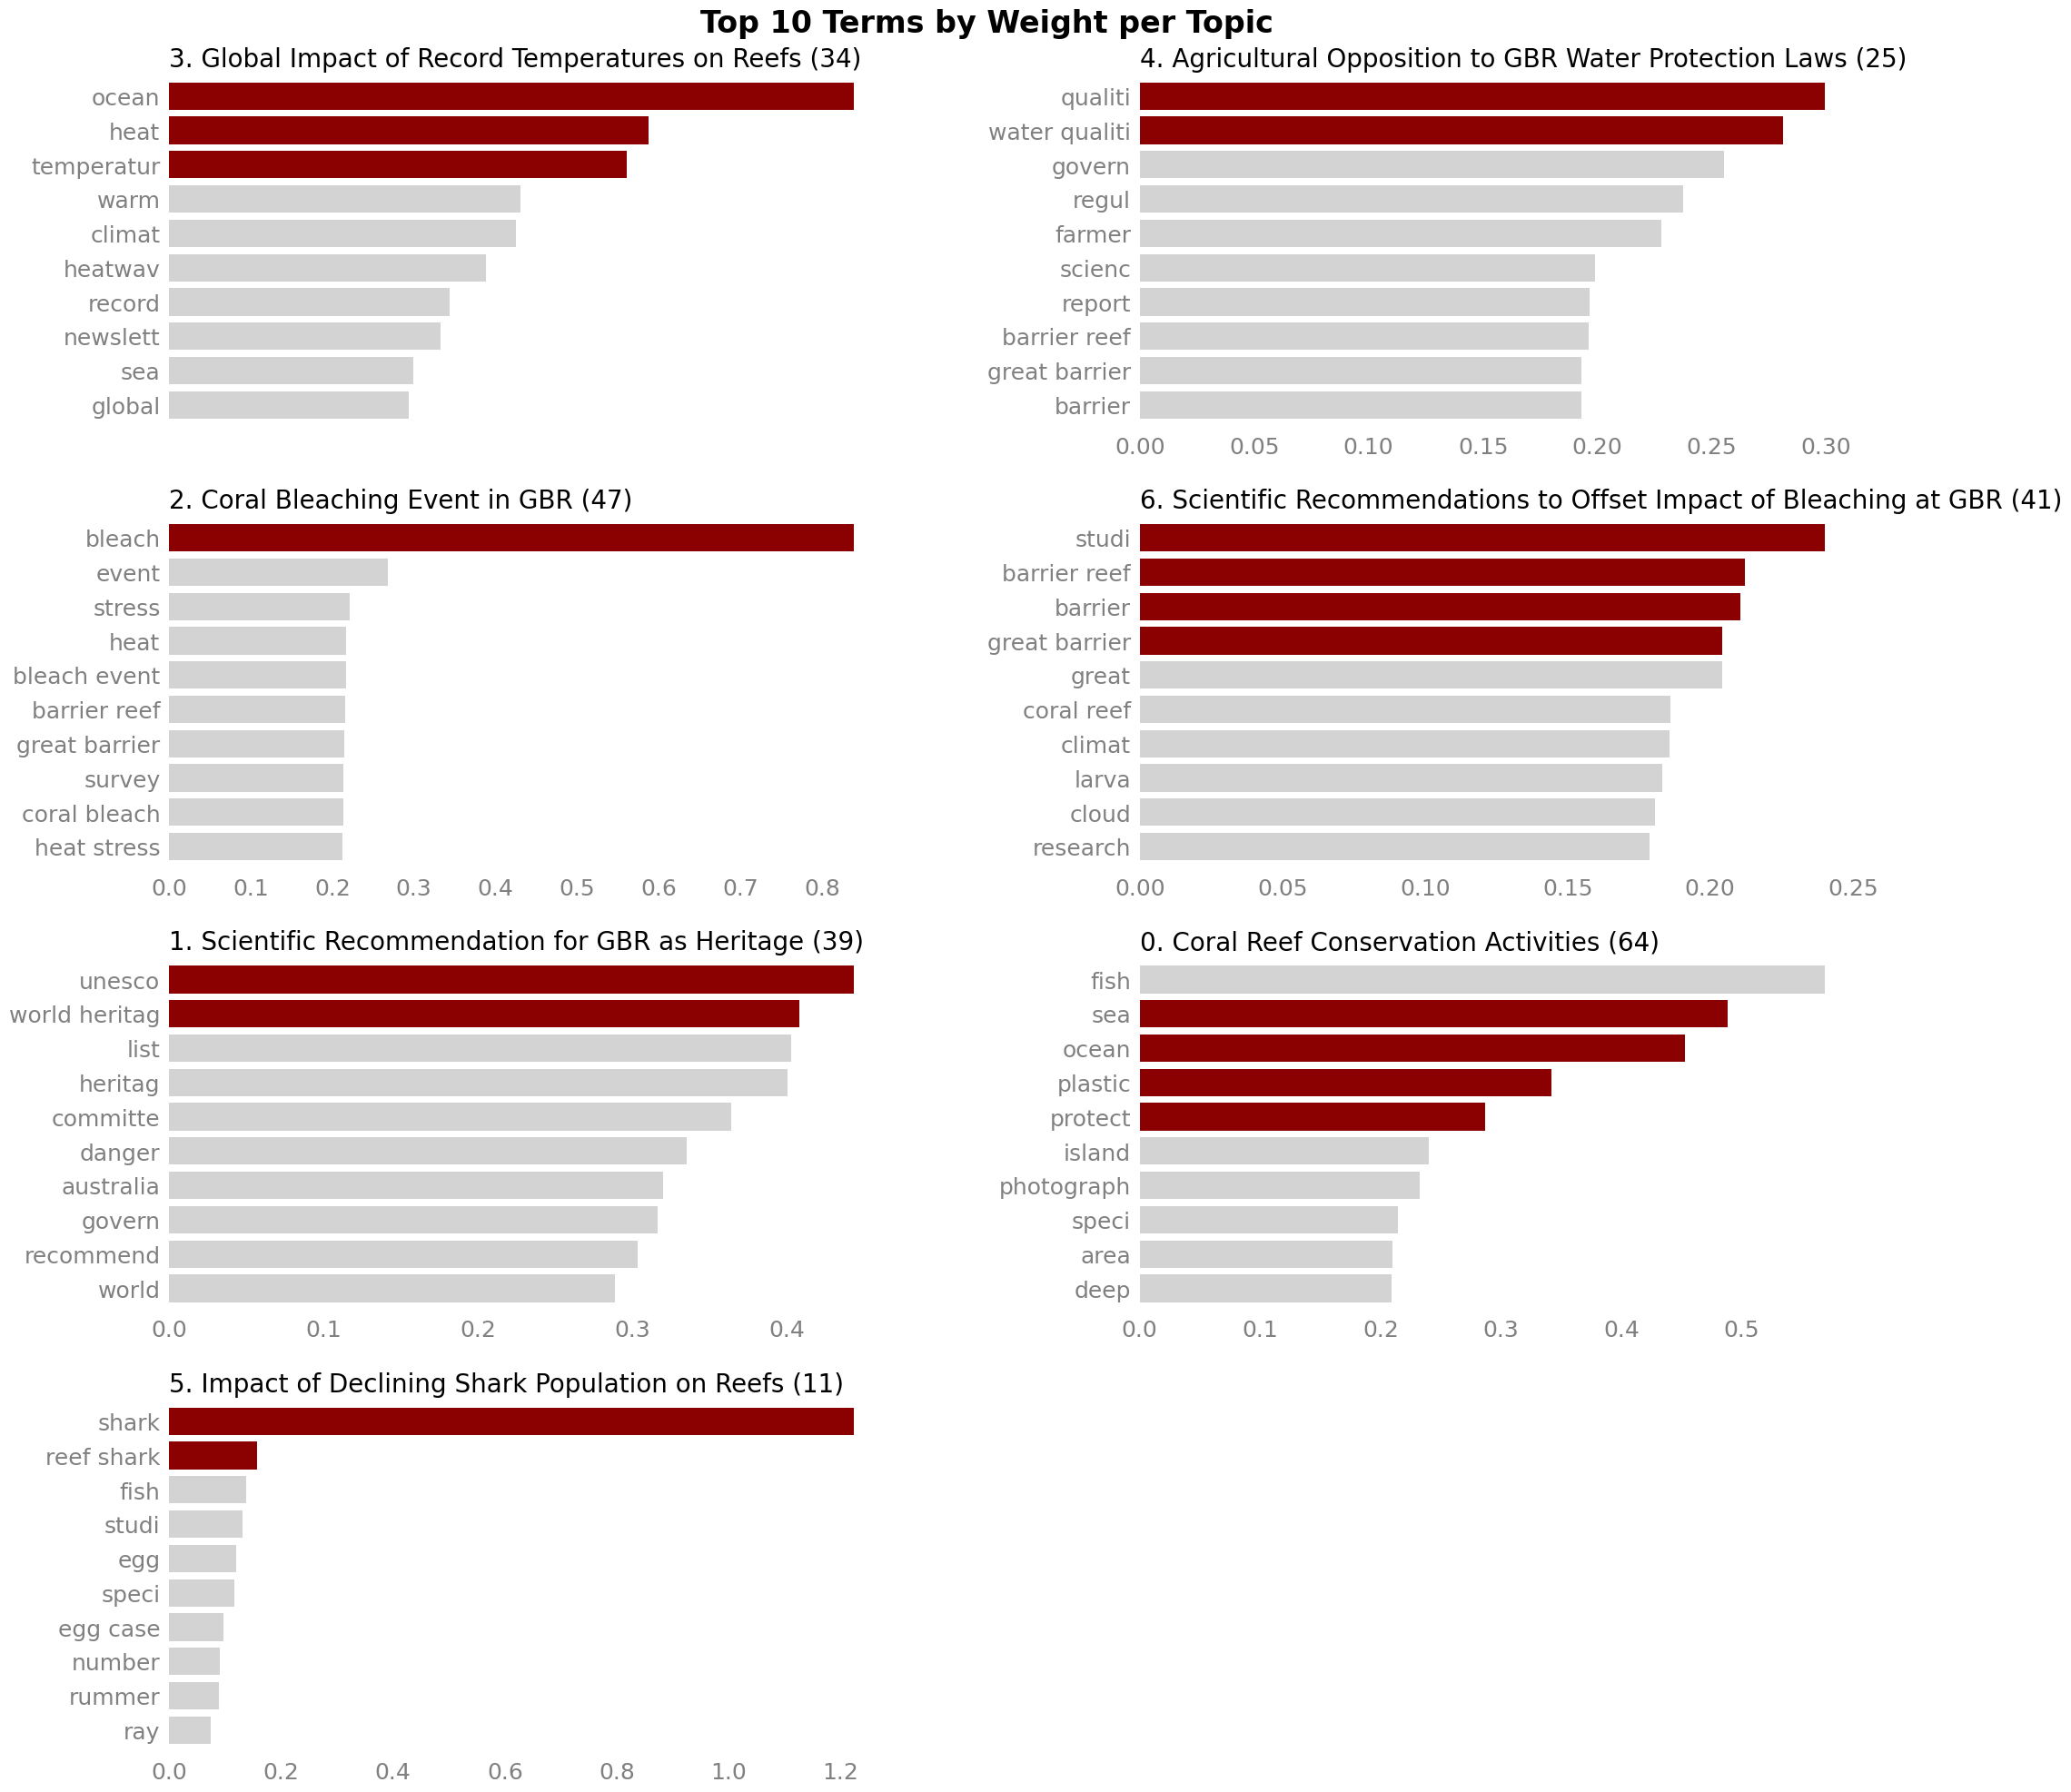

In [10]:
fig = plt.figure(figsize=(24, 24))
grid = plt.GridSpec(4, 2, hspace=0.25, wspace=0.35)
ax1 = fig.add_subplot(grid[0, 0], xticklabels=[])
ax2 = fig.add_subplot(grid[0, 1], yticklabels=[])
ax3 = fig.add_subplot(grid[1, 0], yticklabels=[])
ax4 = fig.add_subplot(grid[1, 1], yticklabels=[])
ax5 = fig.add_subplot(grid[2, 0], yticklabels=[])
ax6 = fig.add_subplot(grid[2, 1], yticklabels=[])
ax7 = fig.add_subplot(grid[3, 0], yticklabels=[])
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
topic_nums = df_topic_word_weights_top_ten['topic_num'].unique().tolist()

fig.suptitle(
    'Top 10 Terms by Weight per Topic',
    x=0.5,
    y=0.91,
    fontweight='bold',
    fontsize=24,
)
for ax, topic_num in zip(*[axes, topic_nums]):
    num_articles = len(df.query(f"topic_num == {topic_num}"))
    df_topic = (
        df_topic_word_weights_top_ten
        .query(f"topic_num == {topic_num}")
    )
    topic_name_truncated = (
        df_topic['topic_name_truncated'].squeeze().iloc[0]
    )

    ax = (
        df_topic
        .sort_values(by=['weight'], ignore_index=True)
        .plot.barh(
            y='weight',
            x='term',
            rot=0,
            color=colors_term_weights[topic_num],
            legend=None,
            width=0.8,
            ax=ax,
        )
    )
    # formatting
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', colors='grey')
    # x-axis label
    _ = ax.set_xlabel(None)
    # y-axis label
    _ = ax.set_ylabel(None)
    # title
    _ = ax.set_title(
        f"{topic_num}. {topic_name_truncated} ({num_articles:,})",
        loc='left',
        fontsize=20,
    )

##### Topic 0

In [11]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 0")
        [['topic_name', 'topic_name_truncated']]
        .drop_duplicates()
        .transpose()
    )

,14
topic_name,Ocean conservation activities to protect and restore coral reefs worldwide
topic_name_truncated,Coral Reef Conservation Activities


In [12]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 0")
        [['webTitle',]]
        .sample(5)
    )

,webTitle
38,"Oceans losing oxygen at unprecedented rate, experts warn"
142,‘Like a work of art’: rare stretch of pristine coral reef discovered off Tahiti
149,World leaders descend on France for ocean summit as Macron puts spotlight on seas
21,"Cuba drastically reforms fishing laws to protect coral reef, sharks and rays"
83,Drexciya: how Afrofuturism is inspiring calls for an ocean memorial to slavery


This topic is focused on worldwide coral reef conservation activities. The top terms *sea*, *ocean*, *plastic* and *protect* reflect this. Interestingly, terms related to *reef* are not found in the top ten.

##### Topic 1

In [13]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 1")
        [['topic_name', 'topic_name_truncated']]
        .drop_duplicates()
        .transpose()
    )

,9
topic_name,Scientific recommendation to place GBR on list of in-danger heritage sites due to consequences of global warming
topic_name_truncated,Scientific Recommendation for GBR as Heritage


In [14]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 1")
        [['webTitle',]]
        .sample(5)
    )

,webTitle
106,Unesco recommends Great Barrier Reef world heritage site should be listed as ‘in danger’
246,"Set more ambitious climate targets to save Great Barrier Reef, Unesco urges Australia"
113,Australia demands world heritage experts visit Great Barrier Reef ahead of ‘in danger’ list decision
16,Great Barrier Reef authority urges 'fastest possible action' on emissions
108,Political ploys and an ocean jewel: what’s behind the UN’s ‘in danger’ warning for the Great Barrier Reef


This topic focuses on articles reporting the recommendation to list GBR as an in-danger heritage site due to the impact of [climate change (one of the causes of coral bleaching events)](https://oceanservice.noaa.gov/facts/coral_bleach.html), which includes coral bleaching. So, it is not surprising that the top terms in this topic include *world heritag* and *unesco* (which publishes the world heritage site list).

##### Topic 2

In [15]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 2")
        [['topic_name', 'topic_name_truncated']]
        .drop_duplicates()
        .transpose()
    )

,3
topic_name,Occurrence of major bleaching events at GBR
topic_name_truncated,Coral Bleaching Event in GBR


This topic is focused on the occurrence of coral bleaching events. It is not surprising that the word with the highest weight in this topic is *bleach*.

##### Topic 3

In [16]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 3")
        [['topic_name', 'topic_name_truncated']]
        .drop_duplicates()
        .transpose()
    )

,0
topic_name,Worldwide occurrence of record ocean temperatures that have potential to trigger bleaching events
topic_name_truncated,Global Impact of Record Temperatures on Reefs


In [17]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 3")
        [['webTitle',]]
        .sample(5)
    )

,webTitle
155,Climate scientists warn global heating means Australia facing more catastrophic storms and floods
192,Marine life hit by ‘perfect storm’ as red list reveals species close to extinction
191,Plibersek’s ‘determination’ alone won’t save the Great Barrier Reef – here’s what needs to happen | Temperature Check
200,"Record ocean temperatures put Earth in ‘uncharted territory’, say scientists"
174,Mediterranean ecosystem suffering ‘marine wildfire’ as temperatures peak


This topic is focused on the occurrence of [record sea temperatures, which in-turn trigger coral bleaching events](https://oceanservice.noaa.gov/facts/coral_bleach.html). The terms *ocean*, *heat* and *temperatur* are the top terms of weight in this topic. These term weights and the article titles suggest the focus of this topic is on climate change and coral bleaching is just one possible consequence of these record temperatures.

##### Topic 4

In [18]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 4")
        [['topic_name', 'topic_name_truncated']]
        .drop_duplicates()
        .transpose()
    )

,1
topic_name,opposition to science-driven GBR water protection laws by agricultural industry
topic_name_truncated,Agricultural Opposition to GBR Water Protection Laws


In [19]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 4")
        [['webTitle',]]
        .sample(5)
    )

,webTitle
69,Unsustainable fishing worsens threats to Great Barrier Reef
256,"Urgent review of Woodside billion-dollar WA gas project needed to protect threatened snake, government advisers say"
71,Scientists claim Coalition misrepresented their evidence to Great Barrier Reef inquiry
4,Great Barrier Reef authority gives green light to dump dredging sludge
32,Australia's science academy attacks 'cherrypicking' of Great Barrier Reef research


This topic is focused on opposition by agricultural industry to laws to protect waste water from damaging the GBR. The emphasis of this topic is more on the regulation around agricultural wastewater (which is [one of the causes of coral bleaching](https://oceanservice.noaa.gov/facts/coral_bleach.html)) entering in the GBR, since the terms *qualiti* and *water qualiti* are at the top in terms of weight, while *barrier*, *great barrier* and *barrier reef* are at the bottom of the top ten.

##### Topic 5

In [20]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 5")
        [['topic_name', 'topic_name_truncated']]
        .drop_duplicates()
        .transpose()
    )

,29
topic_name,Negative impact of declining shark population (due to climate change) on worldwide coral reefs
topic_name_truncated,Impact of Declining Shark Population on Reefs


This topic focuses on the impact of decreased shark populations worldwide on coral reefs, so seeing *shark* and *reef shark* at the top is not surprising. The [absence of sharks negatively impacts reefs' resilience to climate change (rising temperature)](https://phys.org/news/2024-09-sharks-abandoning-stressed-coral-reefs.html) that is known to trigger coral bleaching events. The term *rummer* is related to a [shark researcher's concerns about protection of sharks due to climate change](https://physioshark.org/). There are only 11 articles in this topica and two of the 11 are related to this researcher, as shown below

In [21]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query(
            "(topic_num == 5) & "
            "((webTitle.str.lower().str.contains('rumm')) | "
            "(text.str.lower().str.contains('rumm')))"
        )
        [['webTitle', 'topic_num', 'topic_name_truncated']]
    )

,webTitle,topic_num,topic_name_truncated
82,Baby sharks emerge from egg cases earlier and weaker in oceans warmed by climate crisis,5,Impact of Declining Shark Population on Reefs
84,Will sharks survive? Australian scientists fear for apex predators without more protections,5,Impact of Declining Shark Population on Reefs


##### Topic 6

In [22]:
with pd.option_context('display.max_colwidth', None):
    display(
        df
        .query("topic_num == 6")
        [['topic_name', 'topic_name_truncated']]
        .drop_duplicates()
        .transpose()
    )

,8
topic_name,Scientific recommendations to counter impact of bleaching events at GBR
topic_name_truncated,Scientific Recommendations to Offset Impact of Bleaching at GBR


This topic is focused on scientific studies in which recommendations are proposed to offset the impact of coral bleaching at the GBR. The top four terms capture *reef* and *studi*, which is in line with this topic.

### Aggregated Article Summary per Topic

Transform data

In [23]:
df_articles_summary_by_topic = (
    df
    .groupby(['topic_num', 'topic'], as_index=False)
    .agg({"topic_name": 'count'})
    .rename(columns={"topic_name": "num_articles"})
    .sort_values(by=['num_articles'], ignore_index=True)
)

Show chart

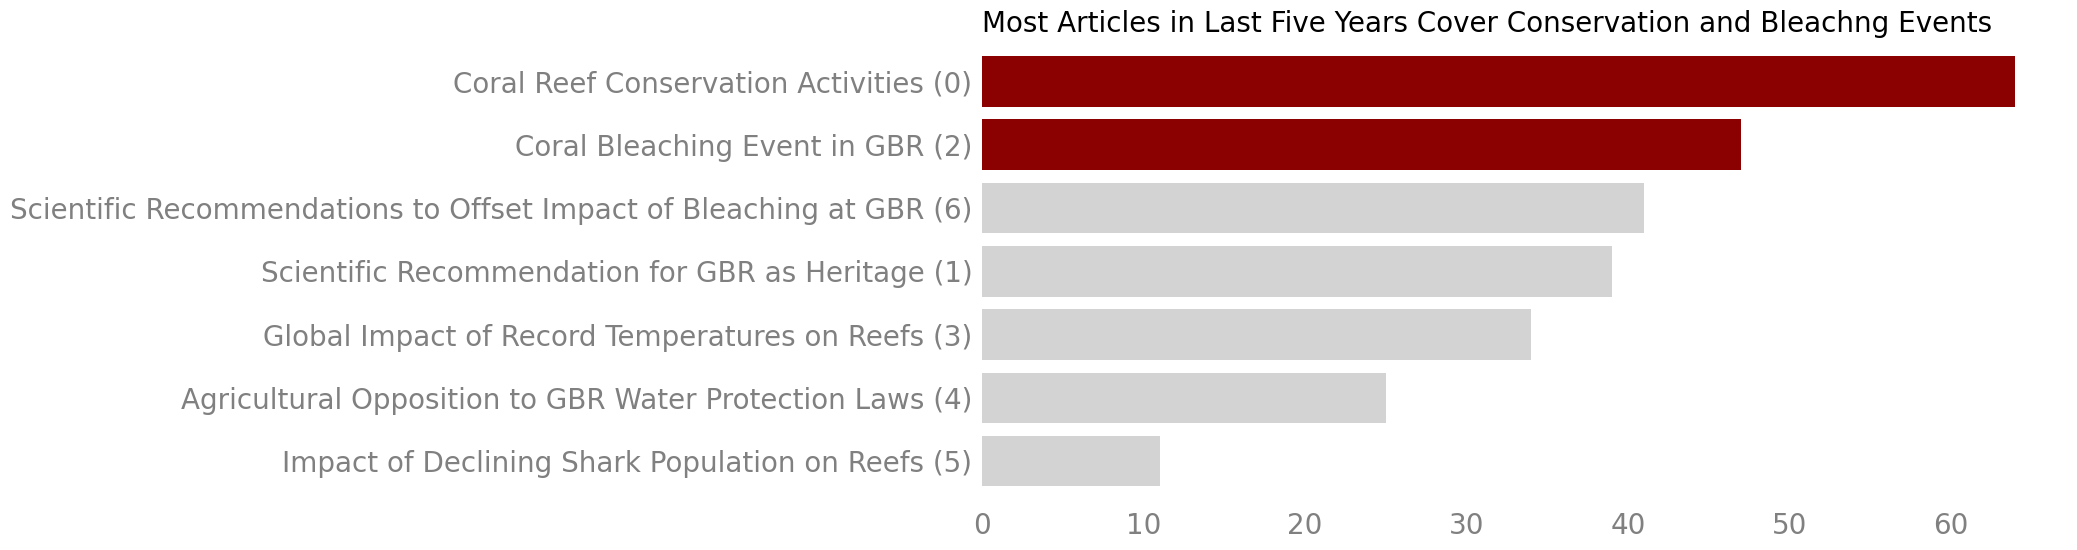

In [24]:
xvar = 'num_articles'
yvar = 'topic'

fig, ax = plt.subplots(figsize=(14, 6))
ax = df_articles_summary_by_topic.plot.barh(
    y=xvar,
    x=yvar,
    ax=ax,
    rot=0,
    width=0.8,
    # facecolor='darkred',
    # edgecolor='darkred',
    color=['lightgrey']*5+['darkred']*2,
    legend=None,
)
# formatting
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', colors='grey')
# x-axis label
_ = ax.set_xlabel(None)
# y-axis label
_ = ax.set_ylabel(None)
# title
_ = ax.set_title(
    (
        "Most Articles in Last Five Years Cover Conservation and Bleachng "
        "Events"
    ),
    loc='left',
    fontsize=20,
)

**Observations**

1. Over the last five years, the most articles were published in topics
   - 0 (coral reef conservation activities)
   - 2 (occurrence of coral bleaching events in GBR)

### Months With Most Articles per Topic

Transform data

In [25]:
df_highest_monthly_popularities = (
    df
    .groupby(['year', 'month'], as_index=False)
    .agg({"topic_name": 'count', 'topic_num': pd.Series.mode})
    .explode('topic_num')
    .rename(columns={"topic_name": "num_articles"})
    .groupby(['topic_num'], as_index=False)
    .agg({"month": "count"})
    .rename(columns={"month": "num_months_most_popular"})
    .assign(
        total_months=len(pd.date_range('2019-01-01', '2024-10-31', freq='MS')),
        frac_months_most_popular=lambda df: (
            100*df['num_months_most_popular']/df['total_months']
        ),
    )
    .merge(
        df[['topic', 'topic_num', 'topic_name_truncated']].drop_duplicates(),
        on=['topic_num'],
        how='left',
    )
    .sort_values(
        by=['num_months_most_popular'], ascending=True, ignore_index=True
    )
    .convert_dtypes()
)

Show chart

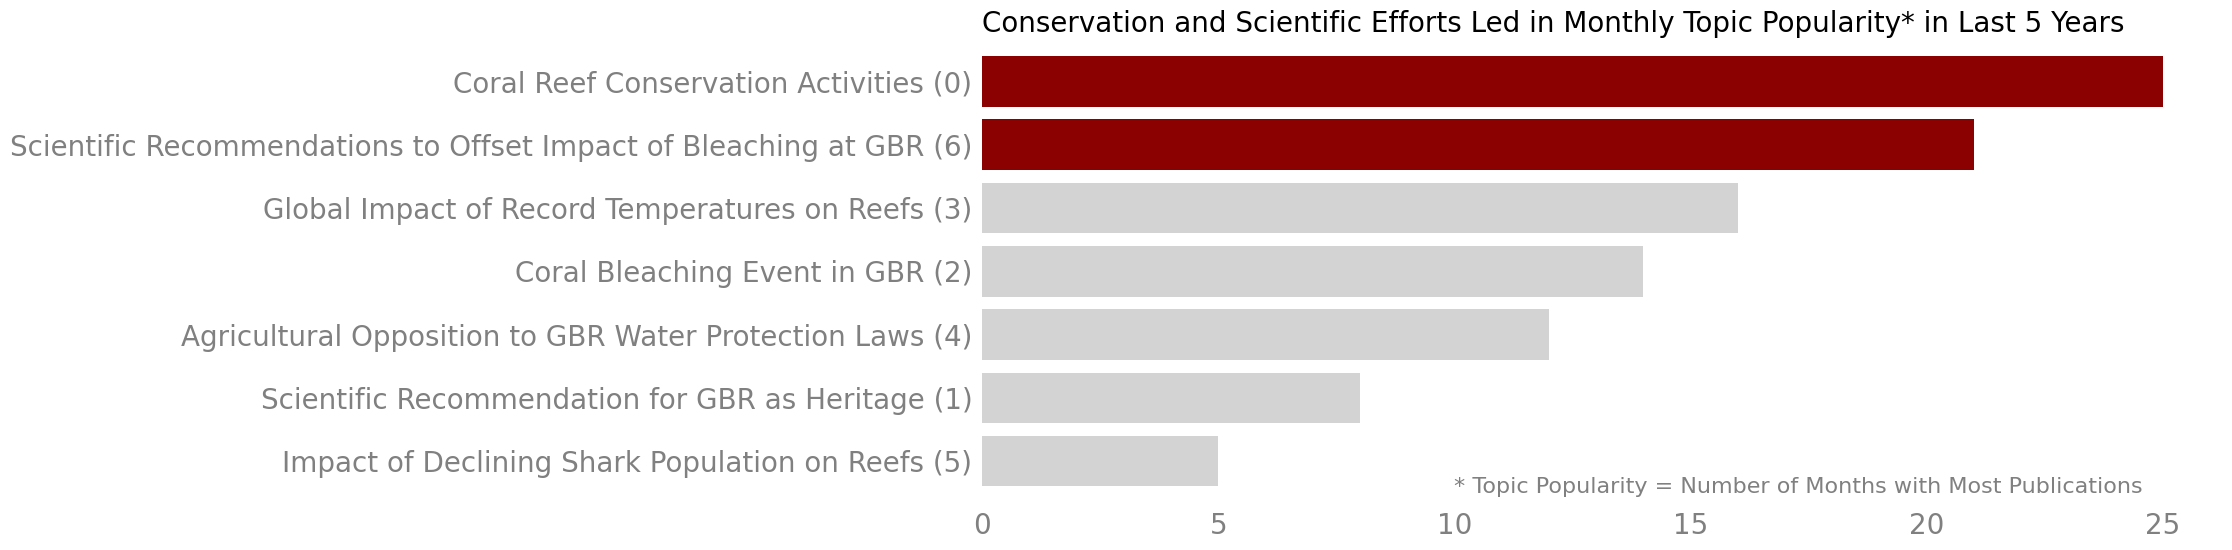

In [26]:
xvar = 'num_months_most_popular'
yvar = 'topic'

fig, ax = plt.subplots(figsize=(16, 6))
ax = df_highest_monthly_popularities.plot.barh(
    y=xvar,
    x=yvar,
    ax=ax,
    rot=0,
    width=0.8,
    # facecolor='darkred',
    # edgecolor='darkred',
    color=['lightgrey']*5+['darkred']*2,
    legend=None,
)
# formatting
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', colors='grey')
# x-axis label
_ = ax.set_xlabel(None)
# y-axis label
_ = ax.set_ylabel(None)
# title
_ = ax.set_title(
    (
        "Conservation and Scientific Efforts Led in Monthly Topic "
        "Popularity* in Last 5 Years"
    ),
    loc='left',
    fontsize=20,
)
# Add a note
_ = ax.annotate(
    '* Topic Popularity = Number of Months with Most Publications',
    xy=(10, -0.5),
    fontsize=16,
    color='grey',
)

**Observations**

1. The two topics that led in monthly topic popularity (topic numbers 0 and 6) were directly related to protection of coral reefs and were in the top three most published topics over the last five years. Since the most articles were published in topic 0 (coral reef conservation activities), it is not surprising that this topic led in monthly topic popularity.

### Article Length per Topic

Transform data

In [27]:
df_monthly_per_topic = (
    df
    # get monthly totals per topic
    .groupby(['year', 'month', 'topic'], as_index=False)
    .agg(
        {
            "topic_name": 'count',
            'char_count': 'median',
            'sentence_count_raw': 'median',
        }
    )
    # set datatypes
    .astype(
        {
            "char_count": pd.Int64Dtype(),
            'sentence_count_raw': pd.Int64Dtype(),
        }
    )
    # rename columns after aggregation
    .rename(columns={"topic_name": "num_articles"})
    .assign(
        # get month start date from year and month
        date=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
    )
    [['topic', 'date', 'num_articles', 'char_count', 'sentence_count_raw']]
    .sort_values(by=['topic', 'date'], ignore_index=True)
)

Show chart with boxplot of article length (using number of characters)

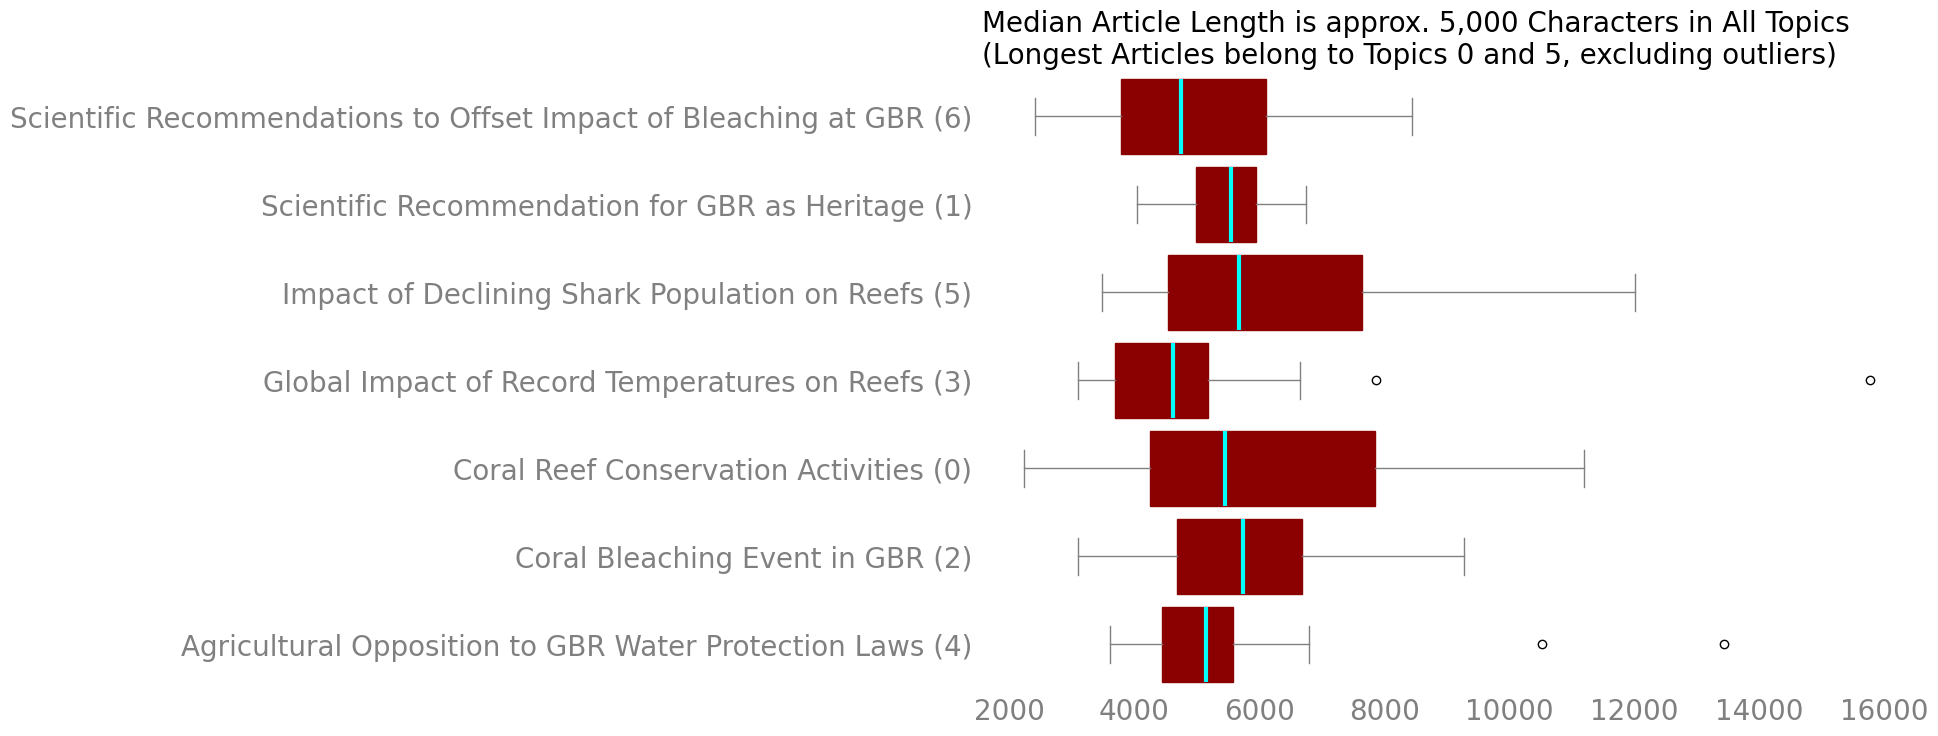

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
props = dict(
    boxes="darkred",
    whiskers="grey",
    caps="grey"
)
_ = df_monthly_per_topic.plot(
    column=['char_count'],
    by='topic',
    vert=False,
    color=props,
    medianprops=dict(linestyle='-', color='cyan', linewidth=3),
    widths=0.85,
    patch_artist=True,
    title=[''],
    kind='box',
    ax=ax,
)

# formatting
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', colors='grey')
# title
_ = ax.set_title(
    (
        "Median Article Length is approx. 5,000 Characters in All "
        "Topics\n(Longest Articles belong to Topics 0 and 5, "
        "excluding outliers)"
    ),
    loc='left',
    fontsize=20,
)

**Observations**

1. Excluding outliers, some of the 11 published articles in Topic 5, which focuses on the *impact of declining shark population on coral reefs' ability to withstand coral bleaching*, are among the longest published by the Guardian on coral bleaching events. The median article length in number of characters was the second longest among all seven topics.
2. The other topic with the longest articles (excluding outliers) was topic 0, which had the most published articles and focused on *coral reef conservation activities*. So, the topics with the most and fewest articles had some of the longest published articles over the last five years.
3. Here, too, the theme of the two topics with the longest articles is focused on (recommended or adopted) actions to protect the world's coral reefs.

### Monthly Articles per Topic

Transform data

In [29]:
topic_monthly_grid = df_from_cartesian_product(
    {
        "topic": df_monthly_per_topic['topic'].unique(),
        "date": df_monthly_per_topic['date'].unique(),
    }
)
df_monthly_per_topic = (
    # LEFT JOIN grid with monthly totals
    topic_monthly_grid
    .merge(
        (
            df_monthly_per_topic
            .drop(columns=['char_count', 'sentence_count_raw'])
        ),
        on=['topic', 'date'],
        how='left',
    )
    # fill missing values in JOINed grid
    .fillna({"num_articles": 0})
    # get datetime and date
    .assign(
        datetime=lambda df: pd.to_datetime(df['date']),
        date=lambda df: pd.to_datetime(df['date']).dt.date,
    )
    # LEFT JOIN JOINed grid with occurrence of bleaching events in GBR
    .merge(
        (
            df_bleaching_event_first_report
            .assign(datetime=lambda df: pd.to_datetime(df['date']))
            .drop(columns=['date'])
        ),
        on='datetime',
        how='left',
    )
    # drop unwanted columns
    .drop(columns=['datetime'])
    # fill missing values in bleach occurrence columns
    .fillna({"is_bleach": False, 'color': "lightgrey"})
    .sort_values(by=['topic', 'date'], ignore_index=True)
    .convert_dtypes()
)

/tmp/ipykernel_6111/991945826.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({"is_bleach": False, 'color': "lightgrey"})


Show chart

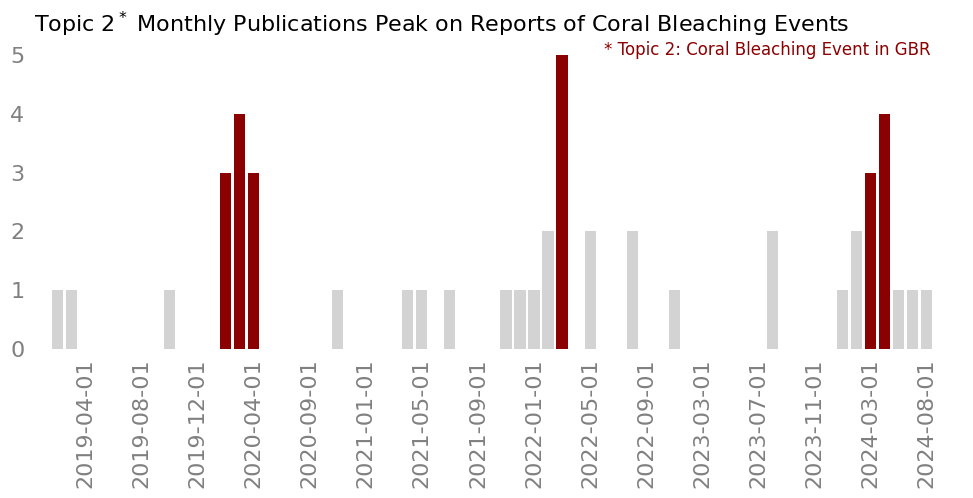

In [30]:
df_topic = df_monthly_per_topic.query("topic.str.contains(' \(2')")
topic_2_name = (
    df_topic['topic']
    .str
    .split(" \(", expand=True)[0]
    .drop_duplicates()
    .squeeze()
)

fig, ax = plt.subplots(figsize=(12, 4))
ax = (
    df_topic
    .plot(
        x='date',
        y='num_articles',
        kind='bar',
        rot=90,
        legend=None,
        width=0.8,
        color=df_topic['color'].squeeze(),
        ax=ax,
    )
)
_ = ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

# formatting
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', colors='grey')
# x-axis label
_ = ax.set_xlabel(None)
# title
_ = ax.set_title(
    (
        "Topic $\mathregular{2^*}$ Monthly Publications Peak on Reports of "
        "Coral Bleaching Events"
    ),
    loc='left',
    fontsize=16,
)
# Add a note
_ = ax.annotate(
    f'* Topic 2: {topic_2_name}',
    xy=(40, 5),
    fontsize=12,
    color='darkred',
)

**Observations**

1. Unsurprisingly, the number of the Guardian's published articles on the coral bleaching events in the GBR (topic number 2) peaks in response to the reports of the occurrence of these events. This is reassuring since it verifies that the choice of topic name was a suitable one for this topic.

## Conclusion

There were two themes to charts produced in this step

1. <span style="color:darkred">Validation of choice of topic names</span> (<span style="color:green">as part of understanding the identified topics</span>)
   - The top 10 terms per topic were charted. These were the terms used in the previous step (`05_topic_modeling.ipynb`) in order to assign a name to each identified topic. These charts help to visualize one of the factors that went into **choosing topic names**.
   - The total monthly publications within topic 2 (occurrence of bleaching events in GBR) were found to peak when coral bleaching events in GBR were reported. This verifies that the **choice of this topic's name** was valid.
2. Identification of the <span style="color:darkred">most published</span> and <span style="color:darkred">longest topics</span> as being <span style="color:darkred">those about protecting world's coral reefs from harmful events that include bleaching</span> (<span style="color:green">as part of understanding topic-publication patterns</span>)
   - The top **two most published topics** among the Guardian's articles over the last five years are related to **coral reef conservation activities worldwide** and the *occurrence of coral bleaching events in the GBR* (the [world's largest coral reef](https://oceanservice.noaa.gov/facts/gbrlargeststructure.html)).
   - The **coral reef conservation activities worldwide** and **scientific recommendations to offset the impact of coral bleaching on coral reefs** were also shown to be the most popular monthly topics (number of months with the most articles) among all of the Guardian's news article publications of the last five years.
   - The longest articles (by character length) were in the **impact of declining shark population on coral reefs' ability to resist coral bleaching** and **coral reef conservation activities**. These topics are also related to methods for protecting the world's coral reefs.